In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

In [29]:
train_pd = pd.read_csv('/Users/javohir/Downloads/digit-recognizer/train.csv')
test_pd = pd.read_csv('/Users/javohir/Downloads/digit-recognizer/test.csv')

In [30]:
train = train_pd.to_numpy()

Splitting the data into train and test datasets

In [31]:
x_train, x_test, y_train,  y_test = train_test_split(train_pd.iloc[:, 1:], train_pd['label'], test_size = 0.25)

Converting the pandas df to numpy and transposing them to use in the later stage:

In [32]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

x_train = x_train.T
x_test = x_test.T
y_train = y_train.T
y_test = y_test.T

Doing the same with the test (not x_test) dataset:

In [33]:
test = test_pd.to_numpy()

test = test.T

Executing one-hot encoding on the y_train data (becuase we use softmax regression, and in order for it to work properly, we need our Y one-hot encoded):

In [34]:
temp = np.zeros((y_train.size, y_train.max()+1))
temp[np.arange(y_train.size), y_train] = 1
y_train = temp.T
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

A lazy way of getting an idea and image of how our data may look like:

In [35]:
#for i in range(100):
#    plt.imshow(np.array(train[i, 1:]).reshape(28, 28))
  # plt.show()

In the following cells, I will be implementing the helper functions that I will use in my final model:

In [36]:
def init_params(layer_dims): # initialize parameters W and b
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

In [37]:
def linear_forw(A, W, b): # linear W * X + b for forward prop
    
    Z = np.dot(W, A) + b
    
    cache = (A, W, b)
    
    return Z, cache

In [38]:
def relu(Z): # ReLU function
    
    A = Z * (Z > 0)
    cache = Z
    
    return A, cache

In [39]:
def sigmoid(Z):
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

In [40]:
def softmax(Z): # Softmax function
    
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    cache = Z
    
    return A, cache

In [41]:
def linear_activation_forw(A_prev, W, b, activation):
    
    Z, linear_cache = linear_forw(A_prev, W, b)
    
    if activation == "relu":
        A, activation_cache = relu(Z)
    
    elif activation =='softmax':
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [42]:
def L_model_forw(X, parameters): # forward propogation with [LINEAR->RELU]*(L-1) -> LINEAR -> SOFTMAX (implements relu L-1 times and performs softmax in the last step)
    
    caches = []
    A = X
    L = len(parameters) // 2 # num of layers in the NN
    
    # relu * (L - 1)
    for l in range(1, L): # loop starts at one because layer 0 is the input
        
        A_prev = A
        A, cache = linear_activation_forw(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)
    
    # softmax in the final layer
    AL, cache = linear_activation_forw(A, parameters['W' + str(L)], parameters['b' + str(L)], 'softmax')
    caches.append(cache)
    

    #print(AL.shape)
    #AL = np.argmax(AL, axis=0)
    
    return AL, caches

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [43]:
def compute_cost(AL, Y): 
    
    m = Y.shape[1]
    AL = np.argmax(AL, axis=0)
    Y = np.argmax(Y, axis=0)
    cost = (sum(AL != Y) / m) * 100
    
    return cost

In [44]:
def linear_backward(dZ, cache): # linear backward (LINEAR) for single layer l
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [45]:
def dZ_relu(dA, cache):
    #Implement the backward propagation for a single RELU unit.
    
    Z = cache
    dZ = np.array(dA, copy=True)
    
    dZ[Z <= 0] = 0
    
    return dZ

In [46]:
def dZ_sigmoid(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [47]:
def linear_activation_backward(AL, Y, dA, cache, activation): # backward prop for LINEAR -> ACTIVATION
    
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = dZ_relu(dA, activation_cache)
    elif activation == 'softmax':
        dZ = AL - Y  # ATTENTION!!!!

    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [48]:
def L_model_backward(AL, Y, caches):
    
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
    
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(AL, Y, dAL, current_cache, activation="softmax")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(AL, Y, dA_prev_temp, current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [49]:
def update_params(params, grads, learning_rate):
    
    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
        parameters['W' + str(l + 1)] = parameters['W' + str(l + 1)] - learning_rate * grads['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] = parameters['b' + str(l + 1)] - learning_rate * grads['db' + str(l + 1)]
        
    return parameters

In [50]:
layers_dims = [784, 40, 20, 10]

Finally, the following is the final function that uses the above helper functions and trains the model:

In [51]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):
    
    "Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX."
    
    np.random.seed(1)
    costs = []
    
    parameters = init_params(layers_dims)
    
    for i in range(num_iterations):
        #print(i, end=' ')
        AL, caches = L_model_forw(X, parameters)
        
        cost = compute_cost(AL, Y)
        
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_params(parameters, grads, learning_rate)
        
        if print_cost and i % 10 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, cost))
        if i % 10 == 0 or i == num_iterations:
            costs.append(cost)
                
    return parameters, costs

In [52]:
parameters, cost = L_layer_model(x_train, y_train, layers_dims, num_iterations = 1231, print_cost = True)  #alpha = 0.00875, layer_dims = [784, 40, 20, 10]

Cost after iteration 0: 92.88253968253967
Cost after iteration 10: 83.87301587301587
Cost after iteration 20: 80.15555555555555
Cost after iteration 30: 53.22539682539682
Cost after iteration 40: 78.1015873015873
Cost after iteration 50: 30.907936507936505
Cost after iteration 60: 38.63174603174603
Cost after iteration 70: 42.044444444444444
Cost after iteration 80: 24.352380952380955
Cost after iteration 90: 18.83809523809524
Cost after iteration 100: 14.428571428571429
Cost after iteration 110: 13.260317460317461
Cost after iteration 120: 17.034920634920635
Cost after iteration 130: 11.657142857142858
Cost after iteration 140: 10.952380952380953
Cost after iteration 150: 10.463492063492064
Cost after iteration 160: 10.711111111111112
Cost after iteration 170: 10.75873015873016
Cost after iteration 180: 9.511111111111111
Cost after iteration 190: 9.222222222222221
Cost after iteration 200: 8.965079365079365
Cost after iteration 210: 8.653968253968253
Cost after iteration 220: 8.422222

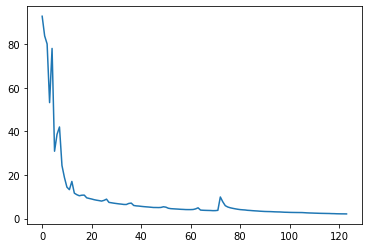

In [53]:
plt.plot(cost)

In [67]:
output, _ = L_model_forw(x_test, parameters)
output

array([[9.98194356e-01, 9.99996739e-01, 1.45091443e-03, ...,
        1.63049931e-07, 3.89747739e-11, 7.95059101e-04],
       [6.17267731e-08, 1.22125472e-12, 4.70104036e-07, ...,
        9.91000162e-01, 9.99333152e-01, 1.43601593e-04],
       [8.88525178e-04, 9.79150878e-07, 6.35289111e-01, ...,
        1.28078099e-03, 2.79951073e-04, 1.15121513e-03],
       ...,
       [9.84700232e-05, 2.25461599e-08, 7.18865972e-04, ...,
        6.18610035e-03, 2.13143230e-04, 9.21690139e-06],
       [7.62257613e-06, 2.05402928e-09, 1.34667134e-04, ...,
        5.61512372e-04, 1.59367403e-04, 4.32344688e-05],
       [2.88133505e-04, 1.84386369e-07, 5.78300442e-06, ...,
        1.27778768e-04, 1.13818830e-06, 1.13688987e-06]])

Converting the probabilities to the actual classifier values (i.e: 0, 1, .. , 9):

In [68]:
output = np.argmax(output, axis=0)

Measuring the accuracy of the model by comparing the output to the ground-truth data (y_test):

In [70]:
print('Accuracy: ', sum(output == y_test) / len(output))

Accuracy:  0.9585714285714285
